In [18]:
# Uncomment to install the required packages
# !pip install git+https://github.com/fagonzalezo/kdm.git

In [19]:
import numpy as np
from scipy.stats import norm
from scipy.stats import gaussian_kde

import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import optimizers
from keras import losses
from keras import metrics
from keras.callbacks import ModelCheckpoint


from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

from kdm.models import KDMDenEstModel, KDMClassModel, KDMJointDenEstModel
import kdm 

from tqdm import tqdm

import matplotlib.pyplot as plt

### 2.5.1 Discriminative training

The following example illustrates the use of the inference process with joint KDMs. We will use the two moons dataset. The model will be trained using discriminative learning using gradient descent.

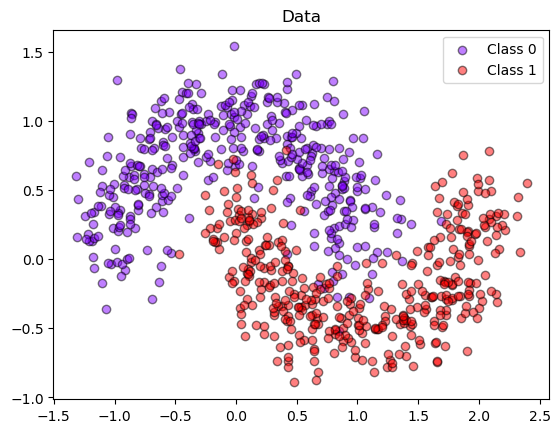

In [20]:
# Function to visualize a 2D dataset
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = plt.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        plt.scatter(this_X[:, 0], this_X[:, 1],  color=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    plt.legend(loc="best")
    plt.title("Data")

# Function to visualize the decission surface of a classifier
def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 50)
    y_vals = np.linspace(min_y, max_y, 50)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    vals = [[XX[i, j], YY[i, j]] for i in range(grid_r) for j in range(grid_c)]
    preds = pred_fun(np.array(vals))
    ZZ = np.reshape(preds, (grid_r, grid_c))
    plt.contourf(XX, YY, ZZ, 100, cmap = plt.cm.coolwarm, vmin= 0, vmax=1)
    plt.colorbar()
    CS = plt.contour(XX, YY, ZZ, 100, levels = [0.1*i for i in range(1,10)])
    plt.clabel(CS, inline=1, fontsize=10)
    plt.xlabel("x")
    plt.ylabel("y")

def gen_pred_fun(clf):
    def pred_fun(X):
        return clf.predict(X)[:, 1]
    return pred_fun

def gen_pred_fun_reg(clf):
    def pred_fun(X):
        return clf.predict(X)
    return pred_fun

# Create a 2 moons dataset
X, y = make_moons(n_samples=1000, noise=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

plot_data(X_train, y_train)

We use the KDMClassModel to train a shallow model that directly apply a KDM inference layer to the raw data. This class assumes a continuos distribution for the input data (i.e. it uses an RBF kernel) and a discrete distribution for the output data. The model is trained using gradient descent with a cross-entropy loss function.

In [21]:
encoded_size = 2
dim_y = 2
encoder = keras.Sequential([keras.layers.Identity()])
n_comp = 30

kdm_model = KDMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder,
                            n_comp=n_comp,
                            sigma=0.05,
                            generative=1.)

# train the classifier
kdm_model.compile(optimizer=optimizers.Adam(learning_rate=5e-3),
                    loss=keras.losses.sparse_categorical_crossentropy,
                    metrics=[metrics.sparse_categorical_accuracy])
kdm_model.predict(X_train[:10])
idx = np.random.randint(X_train.shape[0], size=n_comp)
kdm_model.init_components(X_train[idx], 
                          np.eye(2)[y_train[idx]],
                          init_sigma=False)

kdm_model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 10.1624 - sparse_categorical_accuracy: 0.7998
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.0504 - sparse_categorical_accuracy: 0.9741
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.8408 - sparse_categorical_accuracy: 0.9666
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.7066 - sparse_categorical_accuracy: 0.9756
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.7237 - sparse_categorical_accuracy: 0.9659
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.7164 - sparse_categorical_accuracy: 0.9653
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.6893 - sparse_categorical_accuracy: 0.9628
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.7470 - sparse_categorical_accuracy: 0.9555
Epoch 9/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.6607 - sparse_categorical_acc

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test loss: 5.752257347106934
Test accuracy: 0.9750000238418579
Sigma: 0.27304568886756897


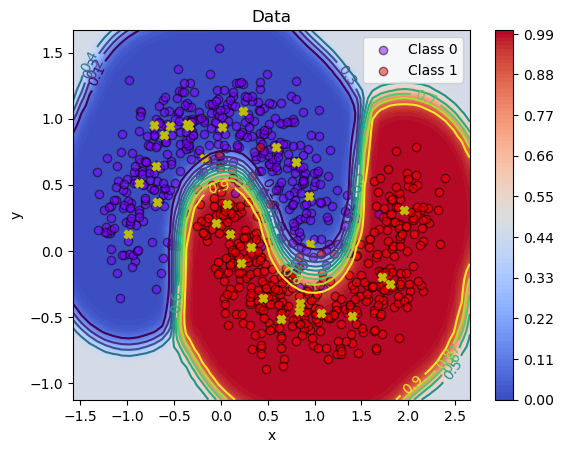

In [22]:
# Plot the decision region
plot_decision_region(X, gen_pred_fun(kdm_model))
plot_data(X_train, y_train)
# plot the prototypes
plt.scatter(kdm_model.kdm.c_x.numpy()[:, 0], kdm_model.kdm.c_x.numpy()[:, 1], c='y', marker='X')
# Evaluate the classifier
score = kdm_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(f'Sigma: {kdm_model.kernel.sigma.numpy()}')

The joint KDM components are shown as yellow crosses. Each component has two elements, an $x$ part and a $y$ part. The components are listed below:

In [23]:
weights = np.abs(kdm_model.kdm.c_w.numpy())
weights /= np.sum(weights)
idx = np.argsort(weights)[::-1]
for i in range(kdm_model.n_comp):
    print(f'Component {i}')
    print(f' Weight: {weights[idx[i]]}')
    print(f' x: {kdm_model.kdm.c_x[idx[i]].numpy()}')
    print(f' y: {kdm_model.kdm.c_y[idx[i]].numpy()}')


Component 0
 Weight: 0.07666918635368347
 x: [0.588034   0.78799105]
 y: [1. 0.]
Component 1
 Weight: 0.07484403252601624
 x: [1.9568822  0.31051636]
 y: [0. 1.]
Component 2
 Weight: 0.06656806915998459
 x: [ 0.44783485 -0.35872728]
 y: [0. 1.]
Component 3
 Weight: 0.06158619374036789
 x: [-0.8688014  0.513283 ]
 y: [1. 0.]
Component 4
 Weight: 0.058639660477638245
 x: [ 1.7211158  -0.20083654]
 y: [0. 1.]
Component 5
 Weight: 0.05450037494301796
 x: [ 1.3972474 -0.4909353]
 y: [0. 1.]
Component 6
 Weight: 0.05331419035792351
 x: [0.942055   0.41645038]
 y: [1. 0.]
Component 7
 Weight: 0.052274372428655624
 x: [-0.98849857  0.12889154]
 y: [1. 0.]
Component 8
 Weight: 0.05214206501841545
 x: [0.2388096 1.0612975]
 y: [1. 0.]
Component 9
 Weight: 0.04685758799314499
 x: [-0.3642179  0.9608642]
 y: [1. 0.]
Component 10
 Weight: 0.04507974535226822
 x: [ 0.21118706 -0.09520707]
 y: [0. 1.]
Component 11
 Weight: 0.036837752908468246
 x: [0.9506156  0.05055766]
 y: [1. 0.]
Component 12
 Wei

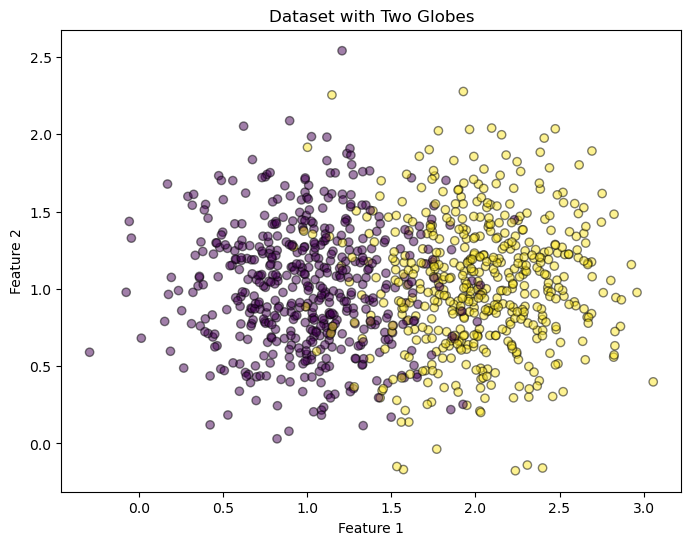

array([[0.1, 0.9],
       [0.1, 0.9],
       [0.9, 0.1],
       [0.1, 0.9],
       [0.9, 0.1],
       [0.9, 0.1],
       [0.1, 0.9],
       [0.9, 0.1],
       [0.9, 0.1],
       [0.1, 0.9]])

In [24]:
from sklearn.datasets import make_blobs

# Create a dataset with two blobs located at (1, 1) and (2, 1)
centers = [(1, 1), (2, 1)]
X_blobs, y_blobs = make_blobs(n_samples=1000, centers=centers, cluster_std=0.4, random_state=42)

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=y_blobs, cmap='viridis', alpha=0.5, edgecolor='k')
plt.title("Dataset with Two Globes")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

y_blobs_ohe = keras.utils.to_categorical(y_blobs)
# scale y_blobs to be in the range [0.1, 0.9]
y_blobs = (y_blobs - np.min(y_blobs)) / (np.max(y_blobs) - np.min(y_blobs)) * 0.8 + 0.1
y_blobs_ohe = (y_blobs_ohe - np.min(y_blobs_ohe)) / (np.max(y_blobs_ohe) - np.min(y_blobs_ohe)) * 0.8 + 0.1

y_blobs_ohe[0:10]


In [26]:
encoded_size = 2
dim_y = 2
encoder = keras.Sequential([keras.layers.Identity()])
n_comp = 30

kdm_model = KDMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder,
                            n_comp=n_comp,
                            sigma=0.1,
                            sigma_trainable=False,
                            generative=1.)

# train the classifier
kdm_model.compile(optimizer=optimizers.Adam(learning_rate=5e-3),
                    loss=keras.losses.categorical_crossentropy,
                    metrics=[metrics.categorical_accuracy])
#kdm_model.predict(X_train[:10])
idx = np.random.randint(X_blobs.shape[0], size=n_comp)
kdm_model.init_components(X_blobs[idx], 
                          y_blobs_ohe[idx],
                          init_sigma=False)

kdm_model.fit(X_blobs, y_blobs_ohe, epochs=10, batch_size=32, verbose=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - categorical_accuracy: 0.8567 - loss: 7.9207
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - categorical_accuracy: 0.8303 - loss: 7.1985
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - categorical_accuracy: 0.8655 - loss: 7.0145
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - categorical_accuracy: 0.8471 - loss: 6.6705
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - categorical_accuracy: 0.8740 - loss: 6.6916
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - categorical_accuracy: 0.8647 - loss: 6.8515
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - categorical_accuracy: 0.8948 - loss: 6.5965
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - categorical_accuracy: 0.8879 - loss: 6.4752
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - categorical_accuracy: 0.8969 - loss: 6.5288
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - categorical_accuracy: 0.8875 - loss

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Test loss: 6.506499290466309
Test accuracy: 0.8949999809265137
Sigma: 0.10000000149011612


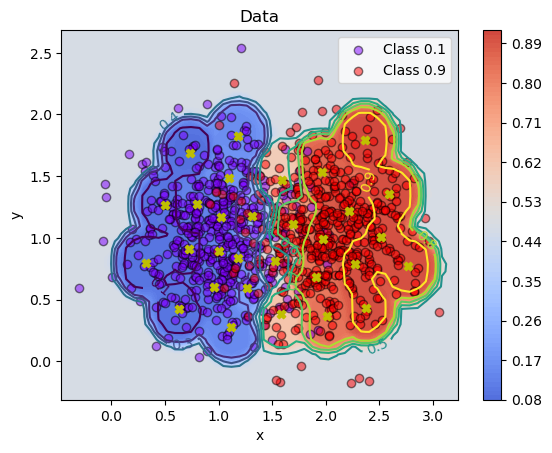

In [27]:
# Plot the decision region
plot_decision_region(X_blobs, gen_pred_fun(kdm_model))
plot_data(X_blobs, y_blobs)
# plot the prototypes
plt.scatter(kdm_model.kdm.c_x.numpy()[:, 0], kdm_model.kdm.c_x.numpy()[:, 1], c='y', marker='X')
# Evaluate the classifier
score = kdm_model.evaluate(X_blobs, y_blobs_ohe, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(f'Sigma: {kdm_model.kernel.sigma.numpy()}')

In [28]:
weights = np.abs(kdm_model.kdm.c_w.numpy())
weights /= np.sum(weights)
idx = np.argsort(weights)[::-1]
for i in range(kdm_model.n_comp):
    print(f'Component {i}')
    print(f' Weight: {weights[idx[i]]}')
    print(f' x: {kdm_model.kdm.c_x[idx[i]].numpy()}')
    v = kdm_model.kdm.c_y[idx[i]].numpy()
    v = keras.utils.normalize(v, order=2, axis=-1)
    print(f' y: {v ** 2}')


Component 0
 Weight: 0.06604058295488358
 x: [1.9763135 0.9917202]
 y: [[0.1475661 0.852434 ]]
Component 1
 Weight: 0.05762045457959175
 x: [2.2114549 1.218453 ]
 y: [[0.10961929 0.8903806 ]]
Component 2
 Weight: 0.05603773519396782
 x: [1.6953241 1.114675 ]
 y: [[0.25856376 0.7414362 ]]
Component 3
 Weight: 0.04805971309542656
 x: [0.72032315 0.91124517]
 y: [[0.90256363 0.09743634]]
Component 4
 Weight: 0.04595574364066124
 x: [1.962358  1.5376465]
 y: [[0.1348001 0.8651999]]
Component 5
 Weight: 0.043666012585163116
 x: [1.9055426 0.6798378]
 y: [[0.17406373 0.8259363 ]]
Component 6
 Weight: 0.04318917170166969
 x: [1.5236893 0.8101116]
 y: [[0.5032198  0.49678028]]
Component 7
 Weight: 0.04151461273431778
 x: [2.2730856 0.787758 ]
 y: [[0.09678173 0.9032182 ]]
Component 8
 Weight: 0.040433187037706375
 x: [1.0974087 1.4854007]
 y: [[0.82523465 0.17476547]]
Component 9
 Weight: 0.04032329097390175
 x: [1.0193995 1.1689475]
 y: [[0.89103675 0.10896336]]
Component 10
 Weight: 0.039996

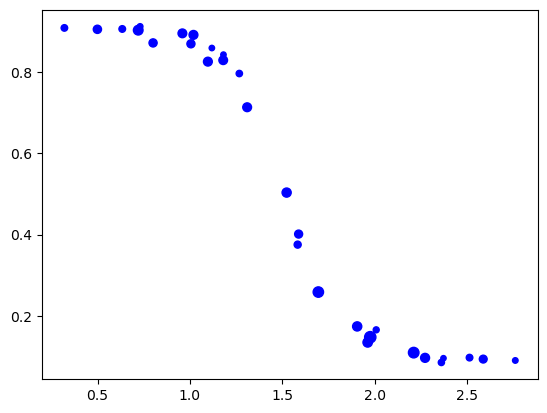

In [32]:
ys  = kdm_model.kdm.c_y.numpy()
ys = keras.utils.normalize(ys, order=2, axis=-1) ** 2
xs = kdm_model.kdm.c_x.numpy()[:, 0]
# plot the prototypes with circles with size proportional to the weights
plt.scatter(xs, ys[:, 0], c='b', marker='o', s=weights*1000)


In [42]:
# to run this example download the data from 
# https://www.kaggle.com/datasets/gonzalorecioc/color-polygon-images
# and set the paths accordingly
targets_path = "/Users/fgonza/Documents/research/code/data/color_poly_images/targets.csv"
images_path = "/Users/fgonza/Documents/research/code/data/color_poly_images/images/content/images"

In [64]:
import pandas as pd

# Load the targets.csv file
targets_df = pd.read_csv(targets_path)

# split the data into train and test
train_df, test_df = train_test_split(targets_df, test_size=0.2, random_state=42)

# Print the maximum and minumum values of bound_circle_r column
print(f"Maximum bound_circle_r: {train_df['bound_circle_r'].max()}")
print(f"Minimum bound_circle_r: {train_df['bound_circle_r'].min()}")

Maximum bound_circle_r: 66
Minimum bound_circle_r: 10


In [83]:
import tensorflow as tf
import pandas as pd

def preprocess_image(image_path):
    """
    Loads an image from the given path and preprocesses it for the dataset.

    Args:
        image_path (str): The file path to the image.

    Returns:
        tf.Tensor: The preprocessed image tensor.
    """
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize to a fixed size (e.g., 224x224)
    image = tf.image.convert_image_dtype(image, tf.float32)  # Convert to float32 and normalize
    image = image / 255.0
    return image

def create_tf_dataset(dataframe, target_column='rotation', batch_size=32, image_folder_path=''):
    """
    Converts a DataFrame into a TensorFlow dataset.

    Args:
        dataframe (pd.DataFrame): The input dataframe containing the data.
        target_column (str): The column to be used as the target/output label.
        batch_size (int): The size of the batches for the dataset.
        image_folder_path (str): The folder path where images are stored.

    Returns:
        tf.data.Dataset: A TensorFlow dataset with input images and target labels.
    """
    # Drop the 'Unnamed: 0' column if it exists
    if 'Unnamed: 0' in dataframe.columns:
        dataframe = dataframe.drop(columns=['Unnamed: 0'])

    # Append image folder path to filenames
    image_paths = [image_folder_path + '/' +  filename for filename in dataframe['filename'].values]
    target = dataframe[target_column].values / 70.# Normalize the target values
    # make target binary label
    target = (target > 0.5).astype(int)

    # Create a TensorFlow dataset from image paths and targets
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, target))

    # Map image paths to preprocessed images
    dataset = dataset.map(lambda path, label: (preprocess_image(path), label), 
                          num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffle and batch the dataset
    dataset = dataset.shuffle(buffer_size=len(dataframe)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

In [91]:
import tensorflow as tf

train_ds = create_tf_dataset(train_df, target_column='bound_circle_r', 
                             batch_size=32, image_folder_path=images_path)

test_ds = create_tf_dataset(test_df, target_column='bound_circle_r',
                            batch_size=32, image_folder_path=images_path)


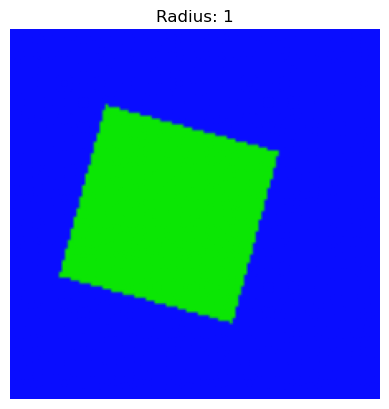

1.0 0.015686275
(224, 224, 3)


2024-12-07 11:31:48.048575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [90]:
# read an image from the dataset and plot it
for image, label in train_ds.take(1):
    plt.imshow(image[0])
    plt.title(f"Radius: {label[0].numpy()}")
    plt.axis('off')
    plt.show()
    print(np.max(image[0].numpy()), np.min(image[0].numpy()))
    print(image[0].shape)

In [130]:

def create_encoder(input_shape, hidden_size, encoded_size):
    """
    Creates an encoder model using a pre-trained MobileNetV2 model.

    Args:
        input_shape (tuple): The shape of the input tensor.
        base_depth (int): The depth of the base model.
        encoded_size (int): The size of the encoded representation.

    Returns:
        keras.Model: The encoder model.
    """
    base_model = keras.applications.MobileNetV2(input_shape=input_shape,
                                                include_top=False,
                                                weights='imagenet')
    
    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(hidden_size, activation=keras.activations.leaky_relu)(x)
    outputs = keras.layers.Dense(encoded_size)(x)

    encoder = keras.Model(inputs, outputs, name='encoder')
    return encoder


def run_experiment(encoded_size=10, 
                   n_comp=64, 
                   sigma_mult=0.2, 
                   epochs=10,
                   batch_size=128):
    
    encoder = create_encoder(input_shape=(224, 224, 3), hidden_size=64, encoded_size=encoded_size)
    print(encoder.summary())
    # warm up the encoder with a small subset
    encoder_wmp = keras.Sequential([encoder, 
                                    keras.layers.Dense(2, activation='softmax')])
    encoder_wmp.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                    loss=losses.sparse_categorical_crossentropy,
                    metrics=[metrics.sparse_categorical_accuracy])

    # train the encoder for 1 epoch
    subset_ds = train_ds.take(10)
    encoder_wmp.fit(subset_ds, epochs=1, verbose=1)

    # Create a KDM classifier model

    kdm_disc = KDMClassModel(encoded_size=encoded_size,
                                dim_y=dim_y,
                                encoder=encoder,
                                n_comp=n_comp,
                                sigma=1.0,
                                w_train=True)

    # initialize the prototypes using random sample from train_ds
    init_prot_x = []
    init_prot_y = []
    for image, label in train_ds.unbatch().take(n_comp):
        init_prot_x.append(image[None, ...])
        init_prot_y.append(label)
    init_prot_x = np.concatenate(init_prot_x, axis=0)
    print(init_prot_x.shape)
    init_prot_y = np.array(init_prot_y)
    kdm_disc.init_components(init_prot_x, keras.ops.one_hot(init_prot_y, 2), 
                            init_sigma=True, sigma_mult=sigma_mult)

    # Compile the model
    kdm_disc.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                        loss=losses.sparse_categorical_crossentropy,
                        metrics=[metrics.sparse_categorical_accuracy])

    # Callback to save the best model
    checkpoint = keras.callbacks.ModelCheckpoint('best_model.weights.h5', 
                                                 save_best_only=True,
                                                 save_weights_only=True)

    # train the classifier
    #kdm_disc.predict(X_train[:10])
    history = kdm_disc.fit(train_ds,
                  epochs=epochs, 
                  batch_size=batch_size, 
                  callbacks=[checkpoint],
                  verbose=1) 

    kdm_disc.load_weights('best_model.weights.h5')
    
    # Evaluate the classifier
    score = kdm_disc.evaluate(test_ds, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    score = kdm_disc.evaluate(train_ds, verbose=0)
    print('Train loss:', score[0])
    print('Train accuracy:', score[1])
    print(f'Sigma: {kdm_disc.kernel.sigma.numpy()}')

    return kdm_disc, history


In [133]:
kdm_disc, history = run_experiment(encoded_size=10, 
                                   n_comp=64, 
                                   sigma_mult=1., 
                                   epochs=1,
                                   batch_size=128)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_48 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_17     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,340,618 (8.93 MB)

 Trainable params: 2,306,506 (8.80 MB)

 Non-trainable params: 34,112 (133.25 KB)

None
10/10 ━━━━━━━━━━━━━━━━━━━━ 113s 4s/step - loss: 0.4763 - sparse_categorical_accuracy: 0.7290


2024-12-07 17:58:19.260230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(64, 224, 224, 3)
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
 93/250 ━━━━━━━━━━━━━━━━━━━━ 2:39 1s/step - loss: 0.8985 - sparse_categorical_accuracy: 0.5524

KeyboardInterrupt: 